# Predicting the Risk of Employee's Attrition

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.preprocessing import StandardScaler, LabelEncoder 

#model
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier # pip install xgboost

from imblearn.over_sampling import SMOTE # !pip install imblearn


### 2. Import Dataset

In [2]:
#https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

df = pd.read_csv("dataset.csv") 
df.shape #1470 rows and 35 columns

(1470, 35)

In [3]:
df.head() #top 5 records, ensure data loaded properly

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### 4. Exploratory Data Analysis

###### check null

> no null value

In [4]:
df.isnull().sum() #no null value

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

###### check duplicate

> no duplicated records

In [5]:
df.duplicated().sum()

0

###### list of attributes

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

###### check if any column has only  1 unique value
>can consider dropping columns with only 1 unique value 

In [18]:
df.loc[:, df.nunique() == 1].columns

Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')

In [19]:
col_to_drop = df.loc[:, df.nunique() == 1].columns

###### check if any column has all unique value which is likley to be a identifier variable

In [20]:
df.loc[:, df.nunique() == df.shape[0]].columns

Index(['EmployeeNumber'], dtype='object')

In [21]:
col_to_drop.append(df.loc[:, df.nunique() == df.shape[0]].columns)

Index(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], dtype='object')

###### Distribution of each column 

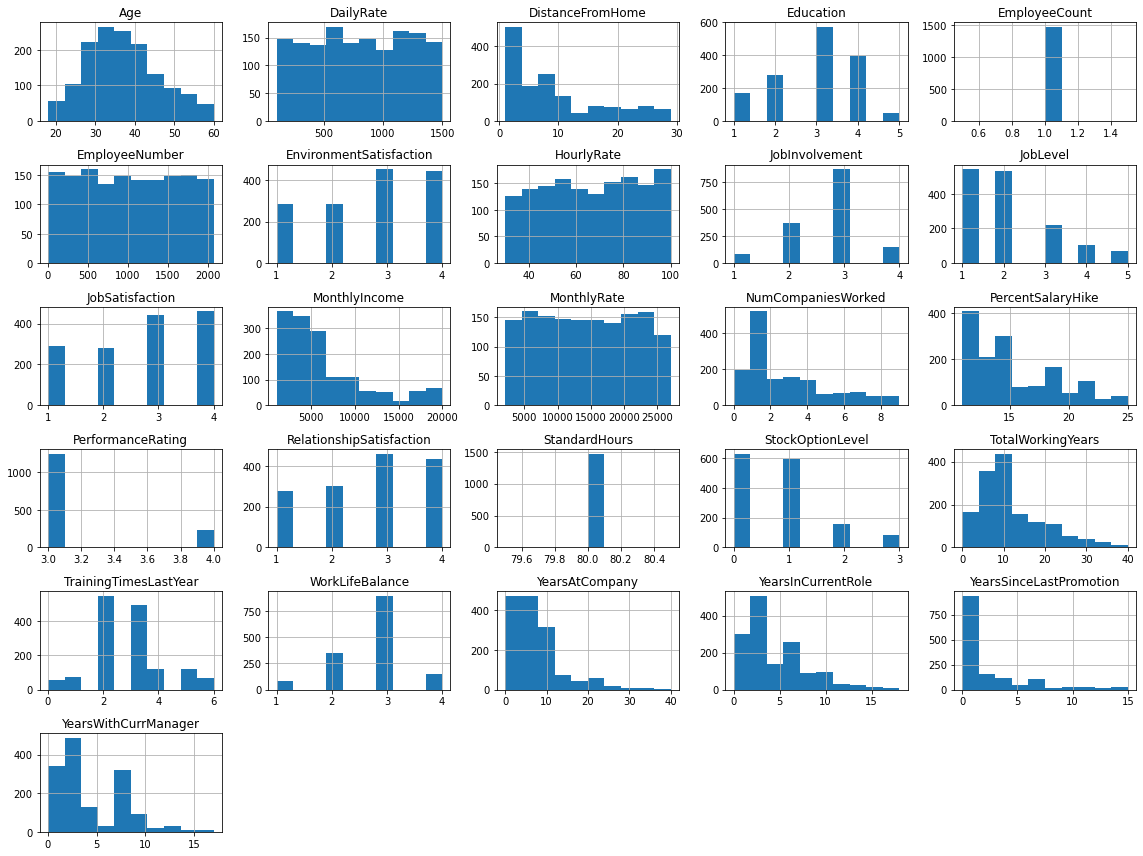

In [22]:
df.hist(figsize=(16,12))
plt.tight_layout()

#### Target Variable - Attrition

> imbalanced dataset

0    1233
1     237
Name: Attrition, dtype: int64


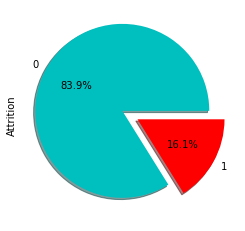

In [55]:
# 0 - 'No' | 1 - 'Yes'
dict_map = {"No":0, "Yes":1}
df.Attrition = df['Attrition'].map(dict_map)  
df['Attrition'].value_counts().plot(kind='pie',explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=['c','r'])
print(df['Attrition'].value_counts())

#### Gender vs Attrition


> The ratio between numbers of males and females in the company are 1.5. <br>
Approximately 6%, 10% of females and males respectively left the company. <br>
The number of males which likely to leave the firm more than number of female.

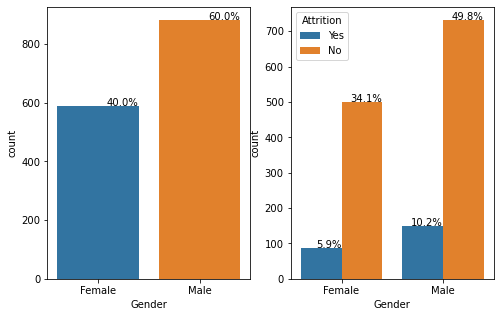

In [36]:
plt.figure(figsize=(8,5))
total = float(len(df))
plt.subplot(1,2,1)

#% of Gender
ay=sns.countplot(x="Gender",data=df)
for p in ay.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ay.annotate(percentage, (x, y),ha='right')
plt.subplot(1,2,2)

#
ax = sns.countplot(x="Gender", hue="Attrition", data=df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()

###### Age vs Attrition

> The majority of employee are between 28 - 36 years old, while the range of age are 18 - 60 <br>
The Company seems to be highly depended on segment of employees younger than 40 years old <br>
A close pattern can be identified where younger employees had higher chance of attrition up to around 35.


<AxesSubplot:xlabel='Age', ylabel='Count'>

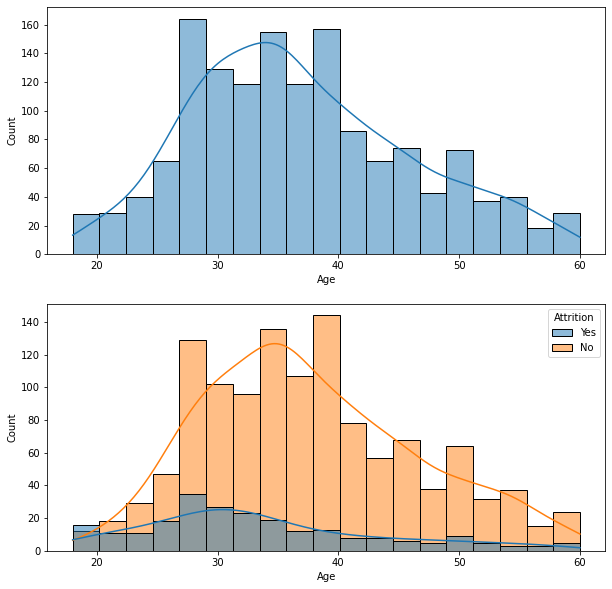

In [44]:
plt.figure(figsize = (10, 10))
plt.subplot(2,1,1)
sns.histplot(x = 'Age', data = df, kde=True )
plt.subplot(2,1,2)
sns.histplot(x = 'Age', hue = 'Attrition', data = df, kde=True )

###### Distance from Home vs Attrition

> Most of our employees have a distance from home in range(1-10 km) <br>
More employees tend to leave when the distance from home is more than 10 km

Text(0.5, 1.0, 'Distance From Home')

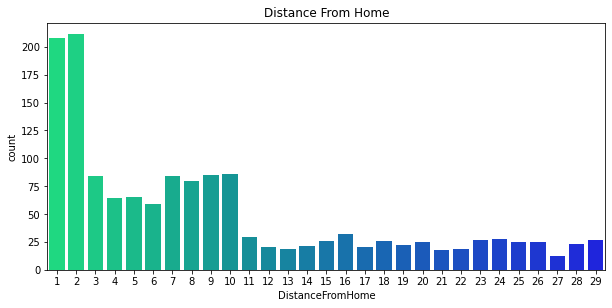

In [46]:
plt.figure(figsize = (10 , 10))
plt.subplot(2 ,1,1)
sns.countplot(x= 'DistanceFromHome' ,data =df ,palette='winter_r')
plt.title('Distance From Home')

In [54]:
df.Attrition.value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

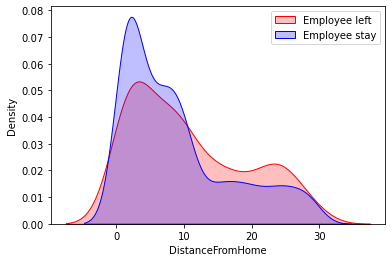

In [57]:
df_left=df[df['Attrition']==1]['DistanceFromHome'] 
df_stay=df[df['Attrition']==0]['DistanceFromHome'] 

sns.kdeplot(df_left, label = 'Employee left', shade = True, color = 'r' )
sns.kdeplot(df_stay, label = 'Employee stay', shade = True, color = 'b')
plt.legend()
plt.show()

# <mark> Please ignore the codes below first </mark>

In [ ]:
df.drop(columns=["StandardHours", "EmployeeNumber", "EmployeeCount","Over18"], inplace=True) 
#drop because values are the same for all employees, hence, redundanct for accruracy

### Feature Engineering

###### Dropping columns with constant value and identifier columns

In [ ]:
df.shape #35 - 4 = 31 remaining cols 

###### Encoding the categorical type data 


In [ ]:
le = LabelEncoder()

In [ ]:
# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

In [ ]:
# convert rest of categorical variable into dummy
df = pd.get_dummies(df, drop_first=True)

In [ ]:
# import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 5))
HR_col = list(df.columns)
HR_col.remove('Attrition')
for col in HR_col:
    df[col] = df[col].astype(float)
    df[[col]] = scaler.fit_transform(df[[col]])
df['Attrition'] = pd.to_numeric(df['Attrition'], downcast='float')
df.head()

In [ ]:
df.info()

### Generate training set and test set with SMOTE

In [ ]:
# Separate input features and target
y = df["Attrition"]
X = df.loc[:, df.columns != 'Attrition']

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)


sm = SMOTE(random_state = 0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

### Handling imbalance data with GAN

In [ ]:
# setting up testing and training sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25, random_state=123)

In [ ]:
import torch.nn as nn
import torch

process = X_train1.copy()
process['target'] = y_train1.copy()

In [ ]:
process

In [ ]:
process.target.value_counts()

In [ ]:
X_for_generate = process.query("target == 1").iloc[:,:-1].values
X_non_default = process.query('target == 0').iloc[:,:-1].values
X_for_generate = torch.tensor(X_for_generate).type(torch.FloatTensor)

n_generate = X_non_default.shape[0] - X_for_generate.shape[0]

In [ ]:
n_generate

In [ ]:
BATCH_SIZE = 50
LR_G = 0.0001           
LR_D = 0.0001           
N_IDEAS = 20            # Initial idea for G generator (random inspiration)


G = nn.Sequential(                      # generator
    nn.Linear(N_IDEAS, 128),            
    nn.ReLU(),
    nn.Linear(128, 44),     
)


D = nn.Sequential(                      # discriminator
    nn.Linear(44, 128),     
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                       # 0-1
)

# optimizator
opt_D = torch.optim.Adam(D.parameters(),lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(),lr=LR_G)


In [ ]:
# GAN
for step in range(3000):
    # Randomly select BATCH real samples with label 1
    chosen_data = np.random.choice((X_for_generate.shape[0]),size=(BATCH_SIZE),replace=False)
    artist_paintings = X_for_generate[chosen_data,:]
    # Generate fake samples using generators
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS, requires_grad=True)           
    G_paintings = G(G_ideas)                  
    
    prob_artist1 = D(G_paintings)               
    # loss
    G_loss = torch.mean(torch.log(1. - prob_artist1))
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    
    prob_artist0 = D(artist_paintings)
    prob_artist1 = D(G_paintings.detach())
    # loss
    D_loss = - torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)
    opt_D.step()

In [ ]:
#GAN fake data
fake_data = G(torch.randn(n_generate,N_IDEAS)).detach().numpy()

X_default = pd.DataFrame(np.concatenate([X_for_generate,fake_data]))
X_default['target'] = 1

X_non_default = pd.DataFrame(X_non_default)
X_non_default['target'] = 0
train_data_gan = pd.concat([X_default,X_non_default])

X_gan = train_data_gan.iloc[:,:-1]
y_gan = train_data_gan.iloc[:,-1]

print(X_gan.shape,y_gan.shape)

In [ ]:
X_gan

In [ ]:
Y_gan.value_counts()

### Modelling

In [ ]:
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [ ]:
# selection of algorithms to consider and set performance measure
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('SVM', svm.SVC(probability=True)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier',DecisionTreeClassifier()))
models.append(('Gaussian NB', GaussianNB()))
models.append(('Adaboost', AdaBoostClassifier()))
models.append(("Gradientboost", GradientBoostingClassifier()))
models.append(("BaggingClassifier", BaggingClassifier()))
models.append(("ExtremeGradientBoost", XGBClassifier()))
models.append(("ExtraTreesClassifier", ExtraTreesClassifier()))

In [ ]:
train_acc_results = []
test_acc_results = []
#roc_auc_score = []
names = []

# set table to table to populate with performance results
col = ['Algorithm','Train Accuracy Mean', 'Test Accuracy', "Test ROC Score"]
df_results = pd.DataFrame(columns=col)
i = 0
# evaluate each model using cross-validation
for name, model in models:
    kfold = KFold(n_splits=10)  # 10-fold cross-validation

    # cv accuracy scoring
    cv_acc_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    train_acc_results.append(cv_acc_results)
    
    #test accuracy scoring
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, pred)
    test_acc_results.append(test_accuracy)
    
    #roc auc score
    roc = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    #roc_auc_score.append(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
    
    names.append(name)
    df_results.loc[i] = [name, round(cv_acc_results.mean()*100, 2), round(test_accuracy*100,2), roc]
    
    i += 1

In [ ]:
df_results.sort_values(by=['Test Accuracy'], ascending=False)

In [ ]:
train_acc_results = []
test_acc_results = []
#roc_auc_score = []
names = []

# set table to table to populate with performance results
col = ['Algorithm','Train Accuracy Mean', 'Test Accuracy', "Test ROC Score"]
df_results = pd.DataFrame(columns=col)
i = 0
# evaluate each model using cross-validation
for name, model in models:
    kfold = KFold(n_splits=10)  # 10-fold cross-validation

    # cv accuracy scoring
    cv_acc_results = cross_val_score(model, X_gan, y_gan, cv=kfold, scoring='accuracy')
    train_acc_results.append(cv_acc_results)
    
    #test accuracy scoring
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, pred)
    test_acc_results.append(test_accuracy)
    
    #roc auc score
    roc = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    #roc_auc_score.append(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
    
    names.append(name)
    df_results.loc[i] = [name, round(cv_acc_results.mean()*100, 2), round(test_accuracy*100,2), roc]
    
    i += 1

In [ ]:
df_results.sort_values(by=['Test Accuracy'], ascending=False)

## Performance

In [ ]:
#To evakuate performances of all the models
def performance(p,ytest,m,xtest):
    print('Accuracy',np.round(accuracy_score(p,ytest),4))
    print('AUC_ROC Score',np.round(roc_auc_score(ytest,m.predict_proba(xtest)[:,1]),4))
    print('Confusion Matrix')
    print(confusion_matrix(p,ytest))
    print('Classification Report:')
    print(classification_report(p,ytest))

## Random Forest

In [ ]:
params={'n_estimators':[100, 200, 300, 400, 500],
            'criterion':['gini','entropy'],
            'max_depth':[None,1,2,3,4,5,6,7,8,9,10],
           'max_features':["sqrt", "log2", None]}

In [ ]:
g=GridSearchCV(RandomForestClassifier(),params,cv=5)

In [ ]:
g.fit(X_train, y_train)

In [ ]:
print(f'Best Params: {g.best_params_}')
print(f'Best Estimator: {g.best_estimator_}')
print(f'Best Score: {g.best_score_}')

In [ ]:
m=RandomForestClassifier(max_features='log2', n_estimators=500)
m.fit(X_train,y_train)
prediction=m.predict(X_test)

In [ ]:
performance(prediction,y_test,m,X_test)

## Gradient Boosting

In [ ]:
params={'n_estimators':[100,200,300,400,500],
      'learning_rate':[0.001,0.01,0.10,],
      'subsample':[0.5,1],
      'max_depth':[1,2,3,4,5,6,7,8,9,10]}

In [ ]:
g=GridSearchCV(GradientBoostingClassifier(),params,cv=5)

In [ ]:
g.fit(xtrain,ytrain)

In [ ]:
print(f'Best Params: {g.best_params_}')
print(f'Best Estimator: {g.best_estimator_}')
print(f'Best Score: {g.best_score_}')

In [ ]:
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, 
                         hyperparameters[name], 
                         cv=10, 
                         n_jobs=-1, scoring="accuracy")
    
    model.fit(X_train, y_train)
    
    print(f'{name}: {model.best_estimator_}')
    print(f'{name}: {model.best_params_}')
    print(f'{name}: {model.best_score_}')
    print("\n")
    
    
    fitted_models[name] = model

In [ ]:
for name, model in fitted_models.items():
    print('Results for:', name)
    
    # obtain predictions
    pred = fitted_models[name].predict(X_test)

    # accuracy score
    print('Accuracy:', accuracy_score(y_test, pred))
    
    # precision
    precision = cm[1][1]/(cm[0][1]+cm[1][1])
    print('Precision:', precision)
    
    # recall
    recall = cm[1][1]/(cm[1][0]+cm[1][1])
    print('Recall:', recall)
    print("\n")